평가기준
- CutMix와 MixUp을 적용한 데이터셋으로 훈련한 각각의 ResNet 모델이 수렴
- 각 Augmentation 기법을 적용하고, 그에 따른 성능 비교 분석 및 문제점을 서술
- 기본 Augmentation, CutMix, MixUp이 적용된 결과를 시각화와 함께 체계적으로 분석

할일
- base 모델, 기본 aug적용, 기본 + cutmix, 기본 + mixup 모델 생성
- 시각화를 통해 성능 비교
- 결과 분석

In [13]:
# 라이브러리
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
from tensorflow.keras.callbacks import ModelCheckpoint

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
# 상수 선언


In [3]:
# 사용할 함수들 로드
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

def onehot(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label

def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    # print('image_size_x : ', image_size_x)
    # print('image_size_y : ', image_size_y)
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    # 클립 박스의 너비(width)와 높이(height)를 랜덤하게 선택
    # tf.math.sqrt(1 - tf.random.uniform([], 0, 1))는 넓이와 높이가 큰 박스보다 작은 박스가 더 자주 생성되도록 하기 위해 사용
    # tf.random.uniform([], 0, 1): 0과 1 사이의 랜덤한 스칼라 값을 생성합니다.
    # tf.random.uniform([3], 0, 1): 0과 1 사이의 랜덤한 값 3개로 이루어진 1차원 텐서를 생성합니다.
    # tf.random.uniform([2, 3], 0, 1): 0과 1 사이의 랜덤한 값으로 이루어진 2 x 3 크기의 텐서를 생성합니다
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    print('width : ', width)
    print('height : ', height)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+height//2)
    
    return x_min, y_min, x_max, y_max

def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    # 겹치는 영역을 먼저 만듦
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1) 
    # 위 + 겹치는 영역 + 아래로 합침
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

def mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120, image_a=None):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    # 만약 라벨이 스칼라면(정수형 벡터라면) 원-핫 인코딩으로 변경해줌
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        # 배치 내 이미지 순서대로 선택
        image_a = image[i]
        label_a = label[i]
        # 배치 내 다른 이미지 랜덤하게 선택
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        # 작업
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, image_a=image_a))

    # 배치 사이즈만큼 쌓고, shape 맞춰서 반환
    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    elif not is_test and with_mixup:
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
    # if not is_test:
    #     ds = ds.repeat()
    #     ds = ds.shuffle(500)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [4]:
# 데이터 불러오기
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

2024-07-02 21:19:42.285478: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-02 21:19:42.285535: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-02 21:19:42.285545: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-02 21:19:42.415691: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-02 21:19:42.415728: I external/local_xla/xla/stream_executor

In [5]:
# Tensorflow 데이터셋을 로드하면 꼭 feature 정보를 확인해 보세요. 
print(ds_info.features)
# 데이터의 개수도 확인해 봅시다. 
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))
# 클래스 수
print(ds_info.features["label"].num_classes)
# 클래스 이름
print(ds_info.features["label"].names)

print(ds_info.splits['train'].num_examples)
print(int(ds_info.splits['train'].num_examples/16))

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'image/filename': Text(shape=(), dtype=string),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=float32),
    }),
})
tf.Tensor(12000, shape=(), dtype=int64)
tf.Tensor(8580, shape=(), dtype=int64)
120
['n02085620-chihuahua', 'n02085782-japanese_spaniel', 'n02085936-maltese_dog', 'n02086079-pekinese', 'n02086240-shih-tzu', 'n02086646-blenheim_spaniel', 'n02086910-papillon', 'n02087046-toy_terrier', 'n02087394-rhodesian_ridgeback', 'n02088094-afghan_hound', 'n02088238-basset', 'n02088364-beagle', 'n02088466-bloodhound', 'n02088632-bluetick', 'n02089078-black-and-tan_coonhound', 'n02089867-walker_hound', 'n02089973-english_foxhound', 'n02090379-redbone', 'n02090622-borzoi', 'n02090721-irish_wolfhound', 'n02091032-italian_greyhound', 'n02091134-whippet', 'n02091244-ibizan_hound', 'n02091467-norwegian_elkhound', 'n02091635-otterho

In [15]:
# 학습에 사용할 상수 정의
# EPOCH = 20  # Augentation 적용 효과를 확인하기 위해 필요한 epoch 수
EPOCH = 3
batch_size = 16
learning_rate = 0.001
num_classes = ds_info.features["label"].num_classes # 미리 정의되어야  함수들이 돌아감
checkpoint_filepath = './models/'

In [16]:
# 데이터 증강 적용
ds_train_no_aug = apply_normalize_on_dataset(ds_train, batch_size=batch_size)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True, batch_size=batch_size)
ds_train_aug_cutmix = apply_normalize_on_dataset(ds_train, with_aug=True, with_cutmix=True, batch_size=batch_size)
ds_train_aug_mixup = apply_normalize_on_dataset(ds_train, with_aug=True, with_mixup=True, batch_size=batch_size)
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)

width :  Tensor("Cast_3:0", shape=(), dtype=int32)
height :  Tensor("Cast_4:0", shape=(), dtype=int32)
width :  Tensor("Cast_9:0", shape=(), dtype=int32)
height :  Tensor("Cast_10:0", shape=(), dtype=int32)
width :  Tensor("Cast_15:0", shape=(), dtype=int32)
height :  Tensor("Cast_16:0", shape=(), dtype=int32)
width :  Tensor("Cast_21:0", shape=(), dtype=int32)
height :  Tensor("Cast_22:0", shape=(), dtype=int32)
width :  Tensor("Cast_27:0", shape=(), dtype=int32)
height :  Tensor("Cast_28:0", shape=(), dtype=int32)
width :  Tensor("Cast_33:0", shape=(), dtype=int32)
height :  Tensor("Cast_34:0", shape=(), dtype=int32)
width :  Tensor("Cast_39:0", shape=(), dtype=int32)
height :  Tensor("Cast_40:0", shape=(), dtype=int32)
width :  Tensor("Cast_45:0", shape=(), dtype=int32)
height :  Tensor("Cast_46:0", shape=(), dtype=int32)
width :  Tensor("Cast_51:0", shape=(), dtype=int32)
height :  Tensor("Cast_52:0", shape=(), dtype=int32)
width :  Tensor("Cast_57:0", shape=(), dtype=int32)
height

TypeError: in user code:

    File "/tmp/ipykernel_48957/253163516.py", line 14, in onehot  *
        label = tf.one_hot(label, num_classes)

    TypeError: Value passed to parameter 'indices' has DataType float32 not in list of allowed values: uint8, int8, int32, int64


In [ ]:
# 모델 정의

# 모델 이름 리스트
model_names = ['resnet50', 'aug_resnet50', 'cutmix_resnet50', 'mixup_resnet50']
models = {}

# 모델 생성 반복문
for name in model_names:
    model = keras.models.Sequential([
        keras.applications.resnet.ResNet50(
            include_top=False,
            weights='imagenet',
            input_shape=(224, 224, 3),
            pooling='avg',
        ),
        keras.layers.Dense(num_classes, activation='softmax')
    ])
    models[name] = model

In [18]:
# 학습
model_name = 'resnet50'

models[model_name].compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate, clipnorm=1.),
    metrics=['accuracy'],
)

# ModelCheckpoint 콜백 설정
checkpoint_callback = ModelCheckpoint(
    filepath=f'{checkpoint_filepath}{model_name}_best_model.keras',
    monitor='val_loss',  # 검증 정확도를 모니터링
    save_best_only=True,  # 검증 정확도가 가장 높은 모델 저장
    mode='max',  # 검증 정확도가 최대일 때 저장
    save_weights_only=False,  # 전체 모델 저장
    verbose=1  # 저장 여부를 출력
)

history_resnet50_no_aug = models[model_name].fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    # steps_per_epoch=int(ds_info.splits['train'].num_examples/batch_size), # 사용시 에러 발생
    # validation_steps=int(ds_info.splits['test'].num_examples/batch_size),
    epochs=EPOCH,
    validation_data=ds_test,
    callbacks=[checkpoint_callback],  # 콜백 추가
    verbose=1,
    # use_multiprocessing=True,
)

Epoch 1/3
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9239 - loss: 0.5641
Epoch 1: val_loss improved from -inf to 1.22081, saving model to ./models/resnet50_best_model.keras
750/750 ━━━━━━━━━━━━━━━━━━━━ 88s 89ms/step - accuracy: 0.9239 - loss: 0.5641 - val_accuracy: 0.6543 - val_loss: 1.2208
Epoch 2/3
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.8993 - loss: 0.6079
Epoch 2: val_loss did not improve from 1.22081
750/750 ━━━━━━━━━━━━━━━━━━━━ 63s 84ms/step - accuracy: 0.8993 - loss: 0.6079 - val_accuracy: 0.6585 - val_loss: 1.1966
Epoch 3/3
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.8981 - loss: 0.5936
Epoch 3: val_loss did not improve from 1.22081
750/750 ━━━━━━━━━━━━━━━━━━━━ 62s 83ms/step - accuracy: 0.8981 - loss: 0.5936 - val_accuracy: 0.6601 - val_loss: 1.1814


In [10]:
models['aug_resnet50'].compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_resnet50_aug = models['aug_resnet50'].fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    # steps_per_epoch=int(ds_info.splits['train'].num_examples/batch_size),
    # validation_steps=int(ds_info.splits['test'].num_examples/batch_size),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    # use_multiprocessing=True,
)

Epoch 1/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 88s 88ms/step - accuracy: 0.0790 - loss: 4.5091 - val_accuracy: 0.1502 - val_loss: 3.7782
Epoch 2/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 62s 83ms/step - accuracy: 0.5114 - loss: 2.1021 - val_accuracy: 0.5683 - val_loss: 1.6294
Epoch 3/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 62s 83ms/step - accuracy: 0.6760 - loss: 1.2831 - val_accuracy: 0.6163 - val_loss: 1.3327
Epoch 4/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 62s 82ms/step - accuracy: 0.7866 - loss: 0.8802 - val_accuracy: 0.6721 - val_loss: 1.1199
Epoch 5/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 62s 82ms/step - accuracy: 0.8546 - loss: 0.6098 - val_accuracy: 0.6793 - val_loss: 1.0943
Epoch 6/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 62s 82ms/step - accuracy: 0.9024 - loss: 0.4293 - val_accuracy: 0.6672 - val_loss: 1.1506
Epoch 7/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 62s 82ms/step - accuracy: 0.9417 - loss: 0.2888 - val_accuracy: 0.6852 - val_loss: 1.1029
Epoch 8/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 62s 82ms/step - accuracy: 0.9639 - loss: 0.1974 - 

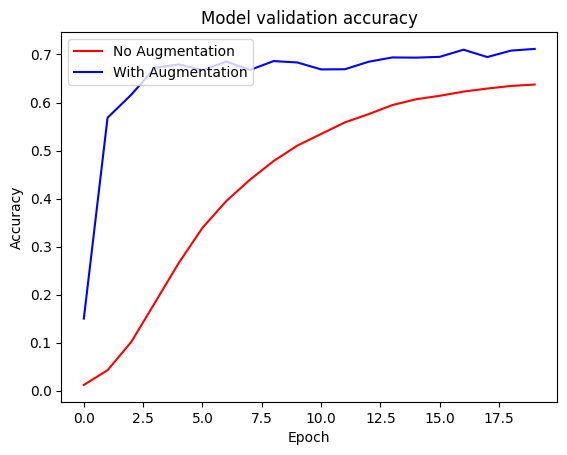

In [11]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation'], loc='upper left')
plt.show()

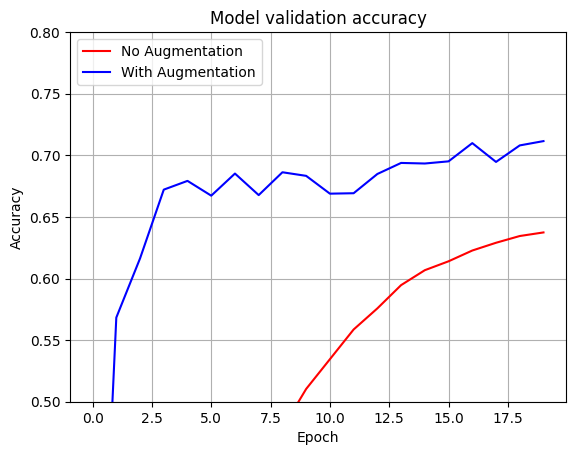

In [12]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation'], loc='upper left')
plt.grid(True)
plt.ylim(0.50, 0.80)    # 출력하고자 하는  Accuracy 범위를 지정해 주세요. 
#plt.ylim(0.72, 0.76)  # EPOCH=20으로 진행한다면 이 범위가 적당합니다. 
plt.show()